# Proyek Akhir: Menyelesaikan Permasalahan Perusahaan Edutech

- Nama: Tema Anggara
- Email: tema.anggara@gmail.com
- Id Laskar AI: A704YBM480 

## Persiapan

### Menyiapkan library yang dibutuhkan

In [1]:
import pandas as pd
import numpy as np
import joblib
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

### Menyiapkan data yang akan diguankan

In [2]:
# 1. Load data
df = pd.read_csv("data.csv", delimiter=';')

In [3]:
df.head()

,Marital_status,Application_mode,Application_order,Course,Daytime_evening_attendance,Previous_qualification,Previous_qualification_grade,Nacionality,Mothers_qualification,Fathers_qualification,...,Curricular_units_2nd_sem_credited,Curricular_units_2nd_sem_enrolled,Curricular_units_2nd_sem_evaluations,Curricular_units_2nd_sem_approved,Curricular_units_2nd_sem_grade,Curricular_units_2nd_sem_without_evaluations,Unemployment_rate,Inflation_rate,GDP,Status
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


## Data Understanding

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Marital_status                                4424 non-null   int64  
 1   Application_mode                              4424 non-null   int64  
 2   Application_order                             4424 non-null   int64  
 3   Course                                        4424 non-null   int64  
 4   Daytime_evening_attendance                    4424 non-null   int64  
 5   Previous_qualification                        4424 non-null   int64  
 6   Previous_qualification_grade                  4424 non-null   float64
 7   Nacionality                                   4424 non-null   int64  
 8   Mothers_qualification                         4424 non-null   int64  
 9   Fathers_qualification                         4424 non-null   i

In [5]:
print("\nMissing values per kolom:")
print(df.isnull().sum())


Missing values per kolom:
Marital_status                                  0
Application_mode                                0
Application_order                               0
Course                                          0
Daytime_evening_attendance                      0
Previous_qualification                          0
Previous_qualification_grade                    0
Nacionality                                     0
Mothers_qualification                           0
Fathers_qualification                           0
Mothers_occupation                              0
Fathers_occupation                              0
Admission_grade                                 0
Displaced                                       0
Educational_special_needs                       0
Debtor                                          0
Tuition_fees_up_to_date                         0
Gender                                          0
Scholarship_holder                              0
Age_at_enrollment      

In [6]:
print("\nJumlah data duplikat:")
print(df.duplicated().sum())


Jumlah data duplikat:
0


In [7]:
# Filter data hanya untuk Graduate dan Dropout
eda_df = df[df["Status"].isin(["Graduate", "Dropout"])].copy()

# Encode 'Status' ke bentuk numerik
le = LabelEncoder()
eda_df['Status_encoded'] = le.fit_transform(eda_df['Status'])

# Hitung korelasi semua fitur numerik terhadap Status_encoded
correlations = eda_df.corr(numeric_only=True)['Status_encoded'].drop('Status_encoded').sort_values(key=abs, ascending=False)

# Tampilkan 10 fitur teratas dengan korelasi tertinggi terhadap Status
print("\nTop 10 fitur paling berkorelasi terhadap Status:")
print(correlations.head(10))


Top 10 fitur paling berkorelasi terhadap Status:
Curricular_units_2nd_sem_approved    0.653995
Curricular_units_2nd_sem_grade       0.605350
Curricular_units_1st_sem_approved    0.554881
Curricular_units_1st_sem_grade       0.519927
Tuition_fees_up_to_date              0.442138
Scholarship_holder                   0.313018
Age_at_enrollment                   -0.267229
Debtor                              -0.267207
Gender                              -0.251955
Application_mode                    -0.244507
Name: Status_encoded, dtype: float64


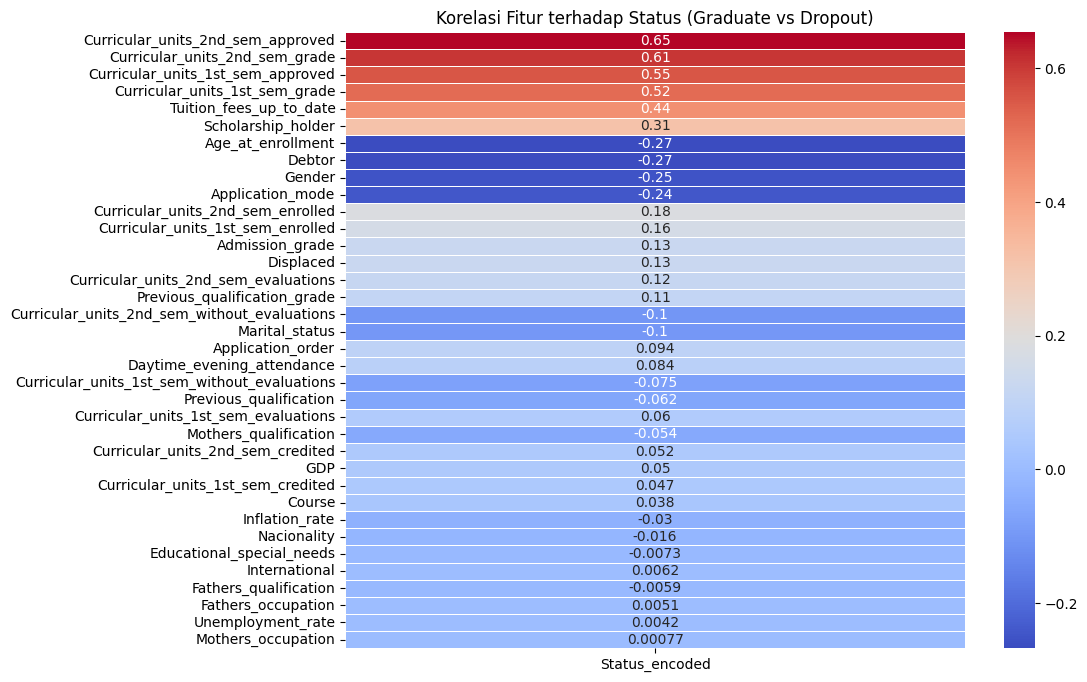

In [8]:
# Visualisasi heatmap korelasi
plt.figure(figsize=(10, 8))
sns.heatmap(correlations.to_frame(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Korelasi Fitur terhadap Status (Graduate vs Dropout)")
plt.show()

- *Curricular_units_2nd_sem_approved:* Semakin banyak mata kuliah lulus di semester 2, semakin besar peluang lulus.
- *Curricular_units_2nd_sem_grade:* Nilai semester 2 yang tinggi berkorelasi kuat dengan kelulusan.
- *Curricular_units_1st_sem_approved:* Sama seperti semester 2, lulus lebih banyak = peluang lulus tinggi.
- *Curricular_units_1st_sem_grade:* Nilai semester 1 juga mempengaruhi kelulusan.

## Data Preparation / Preprocessing

In [9]:
# Label encoding for Status
status_mapping = {"Graduate": 0, "Enrolled": 1, "Dropout": 2}
df["Status"] = df["Status"].map(status_mapping)

# Pisahkan Enrolled
df_enrolled = df[df["Status"] == 1].copy()

# Gunakan hanya Graduate dan Dropout untuk training
df_train = df[df["Status"].isin([0, 2])].copy()
df_train["Dropout_Flag"] = df_train["Status"].apply(lambda x: 1 if x == 2 else 0)

# Feature Selection
categorical_features = [
    "Marital_status", "Application_mode", "Course", "Daytime_evening_attendance",
    "Previous_qualification", "Nacionality", "Mothers_qualification",
    "Fathers_qualification", "Mothers_occupation", "Fathers_occupation",
    "Displaced", "Educational_special_needs", "Debtor",
    "Tuition_fees_up_to_date", "Gender", "Scholarship_holder", "International"
]

numerical_features = [
    "Age_at_enrollment", "Admission_grade",
    "Curricular_units_1st_sem_enrolled", "Curricular_units_1st_sem_approved",
    "Curricular_units_1st_sem_grade", "Curricular_units_1st_sem_without_evaluations",
    "Curricular_units_2nd_sem_enrolled", "Curricular_units_2nd_sem_approved",
    "Curricular_units_2nd_sem_grade", "Curricular_units_2nd_sem_without_evaluations",
    "Unemployment_rate", "Inflation_rate", "GDP"
]

X = df_train[categorical_features + numerical_features]
y = df_train["Dropout_Flag"]

## Modeling

In [10]:
# Preprocessing Pipelines
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

numerical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features),
        ("num", numerical_transformer, numerical_features)
    ]
)

# Full pipeline
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=100,
        class_weight="balanced",
        random_state=42
    ))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Train model
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Marital_status',
                                                   'Application_mode', 'Course',
                                                   'Daytime_evening_attendance',
                                                   'Previous_qualification',
                                                   'Nacionality',
                                                   'Mothers_qualification',
                                                   'Fathers_qualificatio...
                                                   'Curricular_units_1st_sem_grade',
                                                   'Curricular_units_1st_sem_without_evaluations',
                                                   'Curricular_units_2nd_sem_enrolled',
                                                   'Curricular_units_2nd_sem_approved',
                                                   'Curricular_units_2nd_sem_grade',
                                                   'Curricular_units_2nd_sem_without_evaluations',
                                                   'Unemployment_rate',
                                                   'Inflation_rate',
                                                   'GDP'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

## Evaluation

In [11]:
y_pred = model.predict(X_test)

In [12]:
print("=== Classification Report ===")
print(classification_report(y_test, y_pred))

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.93      0.96      0.95       442
           1       0.94      0.89      0.92       284

    accuracy                           0.94       726
   macro avg       0.94      0.93      0.93       726
weighted avg       0.94      0.94      0.93       726



Akurasi keseluruhan: 94%

In [13]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))

=== Confusion Matrix ===
[[426  16]
 [ 31 253]]


- [[426  16]   → Graduate: 426 benar, 16 salah (dikira Dropout).
- [ 31 253]]   → Dropout: 253 benar, 31 salah (dikira Graduate).

In [14]:
# Dapatkan model RandomForest yang sudah dilatih
rf_model = model.named_steps["classifier"]

# Dapatkan nama-nama fitur setelah preprocessing
# 1. Fitur one-hot encoding (kategori)
cat_ohe = model.named_steps["preprocessor"].named_transformers_["cat"] \
    .named_steps["onehot"]
cat_feature_names = cat_ohe.get_feature_names_out(categorical_features)

# 2. Gabungkan dengan fitur numerik (tetap sama karena tidak diubah)
feature_names = np.concatenate([cat_feature_names, numerical_features])

# 3. Ambil feature importance dari Random Forest
importances = rf_model.feature_importances_

# 4. Buat DataFrame untuk visualisasi dan sorting
feature_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Tampilkan 20 fitur teratas
print(feature_importance_df.head(20))

                               Feature  Importance
223  Curricular_units_2nd_sem_approved    0.144544
224     Curricular_units_2nd_sem_grade    0.137818
219  Curricular_units_1st_sem_approved    0.099273
220     Curricular_units_1st_sem_grade    0.084032
209          Tuition_fees_up_to_date_1    0.032377
216                  Age_at_enrollment    0.030575
217                    Admission_grade    0.029204
208          Tuition_fees_up_to_date_0    0.029060
212               Scholarship_holder_0    0.020072
222  Curricular_units_2nd_sem_enrolled    0.017386
218  Curricular_units_1st_sem_enrolled    0.016642
228                                GDP    0.016036
226                  Unemployment_rate    0.015474
227                     Inflation_rate    0.015320
206                           Debtor_0    0.014679
213               Scholarship_holder_1    0.014331
210                           Gender_0    0.011363
207                           Debtor_1    0.010219
6                   Application

Berdasarkan analisis *feature importance* dari model:

| Fitur                               | Pengaruh (Importance) |
| ----------------------------------- | --------------------- |
| `Curricular_units_2nd_sem_approved` | 14.5%                 |
| `Curricular_units_2nd_sem_grade`    | 13.8%                 |
| `Curricular_units_1st_sem_approved` | 9.9%                  |
| `Curricular_units_1st_sem_grade`    | 8.4%                  |

Fitur-fitur ini menunjukkan bahwa performa akademik dua semester pertama sangat menentukan risiko dropout.

## Save model

In [15]:
joblib.dump(model, "model/dropout_model.pkl")

['model/dropout_model.pkl']